## **Data loading and preparation**

In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import requests

In [2]:
# URL to the QuickDraw dataset
dataset_url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'

In [3]:
# Classes to be loaded
classes = ["crown", "chair", "apple", "panda", "bowtie"]

In [4]:
# Load data function for a given class
def download_and_extract(class_name):
    url = f"{dataset_url}{class_name}.npy"
    file_path = f"{class_name}.npy"

    # If data is not already downloaded, download it
    if not os.path.exists(file_path):
        print(f"Downloading {class_name} dataset...")
        response = requests.get(url)
        with open(file_path, 'wb') as f:
            f.write(response.content)

    # Load the data
    data = np.load(file_path)
    print(f"Loaded {class_name}: {data.shape[0]} samples.")
    return data

In [5]:
# Load data for each class
class_data = {}
for class_name in classes:
    class_data[class_name] = download_and_extract(class_name)

Loaded crown: 134089 samples.
Loaded chair: 222706 samples.
Loaded apple: 144722 samples.
Loaded panda: 113613 samples.
Loaded bowtie: 130283 samples.


In [6]:
#Function to visualize samples
def show_sample_images(data, n_samples=5):
    data = data.reshape(-1, 28, 28)  # Ensure data is reshaped to 28x28
    plt.figure(figsize=(10, 2))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i+1)
        plt.imshow(data[i], cmap='gray')
        plt.axis('off')
    plt.show()

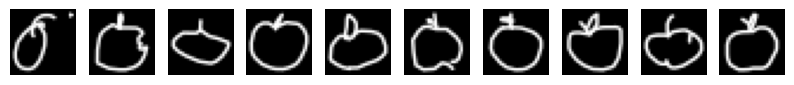

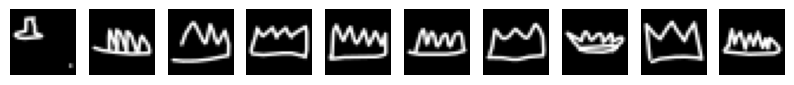

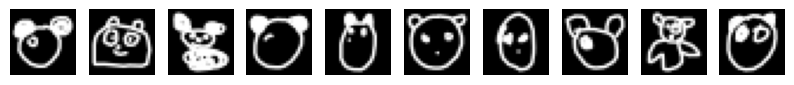

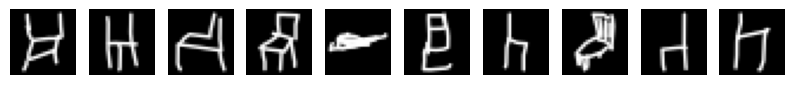

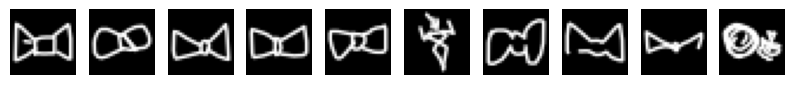

In [ ]:
# Visualizing samples from 'apple' class
show_sample_images(class_data['apple'], 10)

# Visualizing samples from 'crown' class
show_sample_images(class_data['crown'], 10)

# Visualizing samples from 'panda' class
show_sample_images(class_data['panda'], 10)

# Visualizing samples from 'chair' class
show_sample_images(class_data['chair'], 10)

# Visualizing samples from 'bowtie' class
show_sample_images(class_data['bowtie'], 10)

In [7]:
all_data = []
for category in class_data:
    # Convert the category data to float32 type
    category_data = class_data[category].astype('float32')
    # Normalize the data to the range [-1, 1] by dividing by 255 and then scaling to [-1, 1]
    category_data = (category_data / 255.0) * 2 - 1
    all_data.append(category_data)

all_data = np.concatenate(all_data, axis=0)
print(f"Total number of samples: {len(all_data)}")

Total number of samples: 745413


In [8]:
# Define a custom dataset class to handle loading and accessing data for PyTorch DataLoader
class QuickDrawDataset(Dataset):
    def __init__(self, data):
        self.data = torch.FloatTensor(data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx].view(1, 28, 28)

dataset = QuickDrawDataset(all_data)
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [9]:
# Determine the device to use for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## **Models**

### **GAN**

In [29]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, ngf=32):
        super(Generator, self).__init__()
        # Define the architecture using a sequential container
        self.main = nn.Sequential(
            # First transpose convolution layer (deconvolution), maps latent vector to higher dimensions
            nn.ConvTranspose2d(latent_dim, ngf*8, 7, 1, 0, bias=False),  # kernel size 7x7, stride 1, padding 0
            nn.BatchNorm2d(ngf*8),  # Normalize the activations
            nn.ReLU(True),  # Apply ReLU activation function

            # Second transpose convolution layer, downsamples and increases feature maps
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),  # kernel size 4x4, stride 2, padding 1
            nn.BatchNorm2d(ngf*4),  # Normalize activations again
            nn.ReLU(True),  # Apply ReLU activation

            # Third transpose convolution layer, further downsamples and produces final output image
            nn.ConvTranspose2d(ngf*4, 1, 4, 2, 1, bias=False),  # kernel size 4x4, stride 2, padding 1
            nn.Tanh()  # Apply Tanh to normalize output to [-1, 1] (image pixel range)
        )

    def forward(self, z):
        # The forward pass of the Generator:
        # The input z (latent vector) is reshaped to (batch_size, latent_dim, 1, 1) to be used by ConvTranspose2d
        z = z.view(z.size(0), z.size(1), 1, 1)
        imgs = self.main(z)
        return imgs

In [30]:
generator = Generator().to(device)

In [31]:
class Discriminator(nn.Module):
    def __init__(self, ndf=32):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # First convolution layer, extracts features from the input image
            nn.Conv2d(1, ndf*4, 4, 2, 1, bias=False),  # kernel size 4x4, stride 2, padding 1
            nn.BatchNorm2d(ndf*4),  # Normalize activations
            nn.LeakyReLU(0.2, inplace=True),  # Apply LeakyReLU (with negative slope 0.2)

            # Second convolution layer, further extracts features
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),  # kernel size 4x4, stride 2, padding 1
            nn.BatchNorm2d(ndf*8),  # Normalize activations
            nn.LeakyReLU(0.2, inplace=True),  # Apply LeakyReLU again

            # Final convolution layer, produces the output
            nn.Conv2d(ndf*8, 1, 7, 1, 0, bias=False),  # kernel size 7x7, stride 1, padding 0
            nn.Sigmoid()  # Apply Sigmoid to squash the output between 0 and 1 (real or fake)
        )

    def forward(self, input):
        # The forward pass of the Discriminator:
        # Pass input image through the layers defined in self.main
        # After the final layer, output is reshaped to a single value representing probability
        return self.main(input).view(-1, 1)

In [32]:
discriminator = Discriminator().to(device)

In [33]:
# Function to initialize weights for layers in the model
def weights_init(m):
    # Get the class name of the layer (e.g., 'Conv2d', 'BatchNorm2d')
    classname = m.__class__.__name__

    # If the layer is a convolutional layer (Conv2d or ConvTranspose2d)
    if classname.find('Conv') != -1:
        # Initialize the weights with a normal distribution (mean=0, std=0.02)
        nn.init.normal_(m.weight.data, 0.0, 0.02)

    # If the layer is a batch normalization layer (BatchNorm2d)
    elif classname.find('BatchNorm') != -1:
        # Initialize the weights with a normal distribution (mean=1, std=0.02)
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        # Set the bias to 0
        nn.init.constant_(m.bias.data, 0)

In [34]:
generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(256, 1, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (7): Sigmoid()
  )
)

In [ ]:
# Define the adversarial loss function
adversarial_loss = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification

# Set up the optimizers for the Generator and Discriminator
optimizer_G = optim.Adam(generator.parameters(), lr=0.00015, betas=(0.5, 0.9))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.00015, betas=(0.5, 0.9))

### **VAE**

In [10]:
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.distributions import Normal

In [11]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            # First convolutional layer: Input is 28x28, output is 14x14 (downsampled by stride=2)
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            # Second convolutional layer: Input is 14x14, output is 7x7 (further downsampled)
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            # Flatten the output to feed into the linear layers
            nn.Flatten(),
            # Fully connected layer to reduce dimensionality to 256 features
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU()
        )

        # Linear layers to calculate the mean (mu) and variance (log_var) for the latent space
        self.fc_mu = nn.Linear(256, latent_dim)  # Maps to latent_dim
        self.fc_var = nn.Linear(256, latent_dim)  # Maps to latent_dim

    def forward(self, x):
        # Pass the input through the encoder layers
        x = self.encoder(x)
        # Compute the mean (mu) and log variance (log_var) for the latent distribution
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

In [12]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        # Define the first part of the decoder (fully connected layers)
        self.decoder_linear = nn.Sequential(
            # Fully connected layer to expand the latent vector
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            # Another layer to reshape to match the convolutional dimensions
            nn.Linear(256, 64 * 7 * 7),
            nn.ReLU()
        )

        # Define the second part of the decoder (transpose convolutional layers)
        self.decoder_conv = nn.Sequential(
            # First transposed convolutional layer: Input is 7x7, output is 14x14
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            # Second transposed convolutional layer: Input is 14x14, output is 28x28
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh()  # Output normalized between -1 and 1
        )

    def forward(self, x):
        # Pass the latent vector through the fully connected layers
        x = self.decoder_linear(x)
        # Reshape the output to match the dimensions required by ConvTranspose2d
        x = x.view(-1, 64, 7, 7)  # Batch size x channels x height x width
        # Pass through the transposed convolutional layers
        x = self.decoder_conv(x)
        return x

In [13]:
class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.latent_dim = latent_dim
        # Instantiate the encoder and decoder modules
        self.encoder = Encoder(latent_dim)  # Encoder maps input to latent space
        self.decoder = Decoder(latent_dim)  # Decoder reconstructs input from latent space

    def reparameterize(self, mu, log_var):
        # Reparameterization trick to sample z from the latent space distribution.
        std = torch.exp(0.5 * log_var)  # Calculate standard deviation from log variance
        eps = torch.randn_like(std)  # Sample from a standard normal distribution
        return mu + eps * std  # Reparameterized sample

    def forward(self, x):
        # Forward pass through the VAE.
        mu, log_var = self.encoder(x)  # Encode input to latent space parameters
        z = self.reparameterize(mu, log_var)  # Sample from latent space
        return self.decoder(z), mu, log_var  # Decode latent vector to reconstruct input

    def generate(self, num_samples, device):
        # Generate new samples by sampling from the latent space.
        with torch.no_grad():  # Disable gradient computation for generation
            z = torch.randn(num_samples, self.latent_dim).to(device)  # Sample random latent vectors
            samples = self.decoder(z)  # Decode latent vectors into images
        return samples

In [14]:
vae_model = VAE(latent_dim=32)

In [15]:
vae_model.to(device)

VAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Flatten(start_dim=1, end_dim=-1)
      (5): Linear(in_features=3136, out_features=256, bias=True)
      (6): ReLU()
    )
    (fc_mu): Linear(in_features=256, out_features=32, bias=True)
    (fc_var): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Decoder(
    (decoder_linear): Sequential(
      (0): Linear(in_features=32, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=3136, bias=True)
      (3): ReLU()
    )
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 

## **Training and test**

### **GAN**

In [ ]:
epochs = 20

In [ ]:
def train_GAN(epochs=20, data=dataloader):
    G_losses = []
    D_losses = []

    for epoch in range(epochs):
        for i, imgs in enumerate(dataloader):
            batch_size = imgs.size(0)  # Get the size of the batch (number of images)

            # Define ground truth labels
            valid = torch.ones(batch_size, 1).to(device)  # Label for real images
            fake = torch.zeros(batch_size, 1).to(device)  # Label for fake images
            real_imgs = imgs.to(device)  # Move the real images to the device

            # Train Generator
            generator.zero_grad()  # Zero out gradients for the Generator
            z = torch.randn(batch_size, 100).to(device)  # Generate random noise vector (latent space)
            gen_imgs = generator(z)  # Generate fake images using the Generator
            g_loss = adversarial_loss(discriminator(gen_imgs), valid)  # Calculate the Generator loss
            g_loss.backward()  # Backpropagate the loss
            optimizer_G.step()  # Update Generator's weights

            # Train Discriminator
            discriminator.zero_grad()  # Zero out gradients for the Discriminator
            real_loss = adversarial_loss(discriminator(real_imgs), valid)  # Loss for real images
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)  # Loss for fake images
            d_loss = (real_loss + fake_loss) / 2  # Total Discriminator loss (average of real and fake losses)
            d_loss.backward()  # Backpropagate the loss
            optimizer_D.step()  # Update Discriminator's weights

            # Print the losses every 500 batches
            if (i + 1) % 500 == 0:
                print(f"Epoch [{epoch+1}/{epochs}] Batch [{i+1}/{len(dataloader)}] | "
                    f"D loss: {d_loss.item():.4f} G loss: {g_loss.item():.4f}")

            # Save the losses for plotting
            G_losses.append(g_loss.item())
            D_losses.append(d_loss.item())

        # Calculate the average loss for the current epoch and print it
        avg_g_loss = sum(G_losses[-len(dataloader):]) / len(dataloader)
        avg_d_loss = sum(D_losses[-len(dataloader):]) / len(dataloader)
        print(f"==> Epoch [{epoch+1}/{epochs}] | Avg D loss: {avg_d_loss:.4f} Avg G loss: {avg_g_loss:.4f}")

        # Every 5 epochs, generate samples and plot them
        if (epoch + 1) % 5 == 0:
            # Set the generator to evaluation mode (turn off dropout, etc.)
            generator.eval()
            with torch.no_grad():  # Disable gradient computation for faster inference
                # Generate 25 random latent vectors and create 25 fake images
                z = torch.randn(25, 100).to(device)
                generated_images = generator(z).cpu()

            # Create a 5x5 grid to display the generated images
            fig, axes = plt.subplots(5, 5, figsize=(8, 8))
            for i, ax in enumerate(axes.flat):
                ax.imshow(generated_images[i].squeeze(), cmap='gray')  # Show the image
                ax.axis('off')  # Hide the axis
            plt.show()

            # Evaluate the Discriminator's response to the generated images
            discriminator.eval()  # Set the Discriminator to evaluation mode
            with torch.no_grad():  # Disable gradient computation
                validity = discriminator(generated_images.to(device))  # Get the validity of generated images
                print(f"Discriminator output for generated images: {validity.mean().item():.4f}")  # Print the mean validity score

            # Switch both models back to training mode
            generator.train()
            discriminator.train()

            # Plot the losses for the Generator and Discriminator
            plt.figure(figsize=(10, 5))
            plt.title("Generator and discriminator loss during training")
            plt.plot(G_losses, label="G")  # Plot Generator's loss
            plt.plot(D_losses, label="D")  # Plot Discriminator's loss
            plt.xlabel("Iterations")  # Label the x-axis as iterations (or batches)
            plt.ylabel("Loss")  # Label the y-axis as loss
            plt.legend()  # Add a legend to differentiate the two plots
            plt.show()

Epoch [1/20] Batch [500/5824] | D loss: 0.2276 G loss: 9.9273
Epoch [1/20] Batch [1000/5824] | D loss: 0.0196 G loss: 5.9015
Epoch [1/20] Batch [1500/5824] | D loss: 0.0370 G loss: 7.3404
Epoch [1/20] Batch [2000/5824] | D loss: 0.1218 G loss: 3.5462
Epoch [1/20] Batch [2500/5824] | D loss: 0.0075 G loss: 9.1075
Epoch [1/20] Batch [3000/5824] | D loss: 0.0089 G loss: 7.4787
Epoch [1/20] Batch [3500/5824] | D loss: 0.1117 G loss: 7.3109
Epoch [1/20] Batch [4000/5824] | D loss: 0.0078 G loss: 6.4722
Epoch [1/20] Batch [4500/5824] | D loss: 0.0942 G loss: 3.4143
Epoch [1/20] Batch [5000/5824] | D loss: 0.0069 G loss: 6.9678
Epoch [1/20] Batch [5500/5824] | D loss: 0.0110 G loss: 7.1968
==> Epoch [1/20] | Avg D loss: 0.0219 Avg G loss: 7.4249
Epoch [2/20] Batch [500/5824] | D loss: 0.0184 G loss: 5.4193
Epoch [2/20] Batch [1000/5824] | D loss: 0.0092 G loss: 8.3588
Epoch [2/20] Batch [1500/5824] | D loss: 0.0034 G loss: 7.2118
Epoch [2/20] Batch [2000/5824] | D loss: 0.0073 G loss: 7.6744


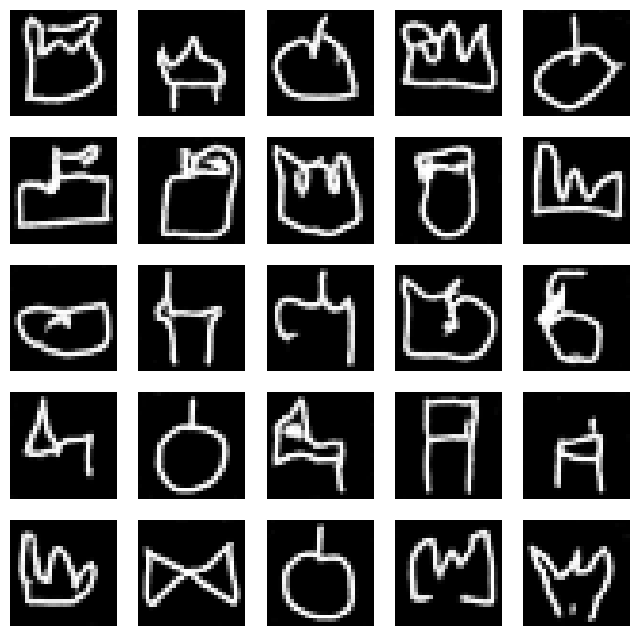

Discriminator output for generated images: 0.0058


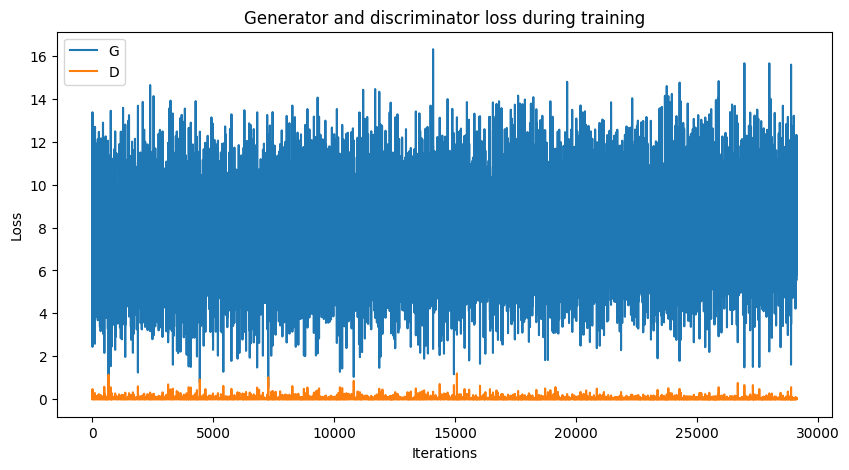

Epoch [6/20] Batch [500/5824] | D loss: 0.0031 G loss: 7.5085
Epoch [6/20] Batch [1000/5824] | D loss: 0.0048 G loss: 10.0337
Epoch [6/20] Batch [1500/5824] | D loss: 0.0045 G loss: 9.7138
Epoch [6/20] Batch [2000/5824] | D loss: 0.0149 G loss: 10.0759
Epoch [6/20] Batch [2500/5824] | D loss: 0.0036 G loss: 9.3888
Epoch [6/20] Batch [3000/5824] | D loss: 0.0041 G loss: 9.1088
Epoch [6/20] Batch [3500/5824] | D loss: 0.0027 G loss: 8.8060
Epoch [6/20] Batch [4000/5824] | D loss: 0.0031 G loss: 8.0319
Epoch [6/20] Batch [4500/5824] | D loss: 0.0034 G loss: 8.7792
Epoch [6/20] Batch [5000/5824] | D loss: 0.0032 G loss: 8.8024
Epoch [6/20] Batch [5500/5824] | D loss: 0.0237 G loss: 11.5281
==> Epoch [6/20] | Avg D loss: 0.0161 Avg G loss: 8.2722
Epoch [7/20] Batch [500/5824] | D loss: 0.0076 G loss: 9.0070
Epoch [7/20] Batch [1000/5824] | D loss: 0.0079 G loss: 8.4572
Epoch [7/20] Batch [1500/5824] | D loss: 0.0056 G loss: 8.1077
Epoch [7/20] Batch [2000/5824] | D loss: 0.0410 G loss: 11.4

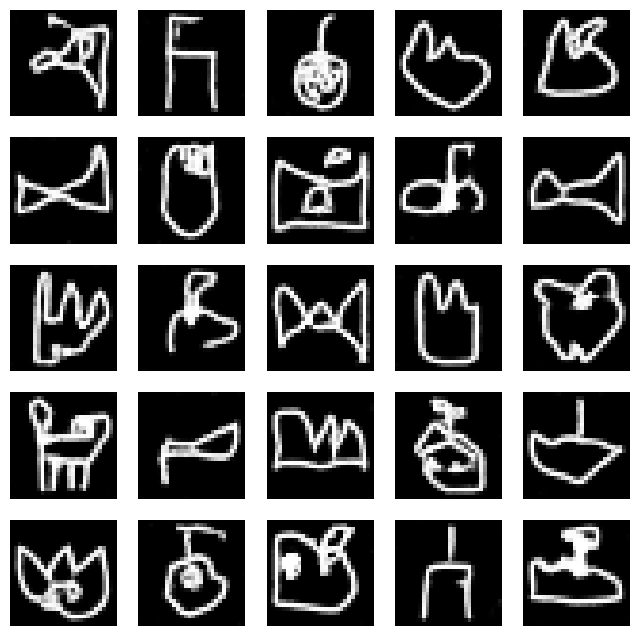

Discriminator output for generated images: 0.0492


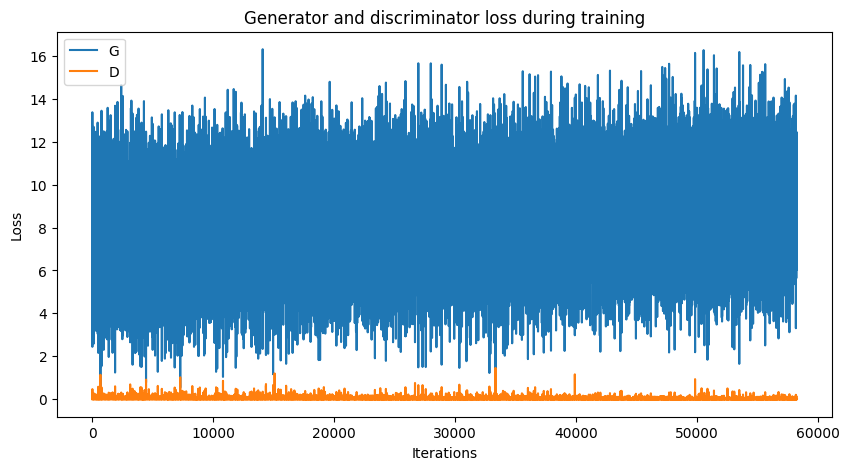

Epoch [11/20] Batch [500/5824] | D loss: 0.1099 G loss: 11.0767
Epoch [11/20] Batch [1000/5824] | D loss: 0.0021 G loss: 8.7009
Epoch [11/20] Batch [1500/5824] | D loss: 0.0057 G loss: 10.4432
Epoch [11/20] Batch [2000/5824] | D loss: 0.0095 G loss: 8.0904
Epoch [11/20] Batch [2500/5824] | D loss: 0.0050 G loss: 8.0601
Epoch [11/20] Batch [3000/5824] | D loss: 0.0012 G loss: 9.0220
Epoch [11/20] Batch [3500/5824] | D loss: 0.0172 G loss: 6.8069
Epoch [11/20] Batch [4000/5824] | D loss: 0.0091 G loss: 11.4502
Epoch [11/20] Batch [4500/5824] | D loss: 0.0044 G loss: 9.4437
Epoch [11/20] Batch [5000/5824] | D loss: 0.0102 G loss: 6.9956
Epoch [11/20] Batch [5500/5824] | D loss: 0.0090 G loss: 11.2823
==> Epoch [11/20] | Avg D loss: 0.0125 Avg G loss: 8.8658
Epoch [12/20] Batch [500/5824] | D loss: 0.0090 G loss: 10.4043
Epoch [12/20] Batch [1000/5824] | D loss: 0.0026 G loss: 9.5625
Epoch [12/20] Batch [1500/5824] | D loss: 0.0023 G loss: 9.1722
Epoch [12/20] Batch [2000/5824] | D loss: 0

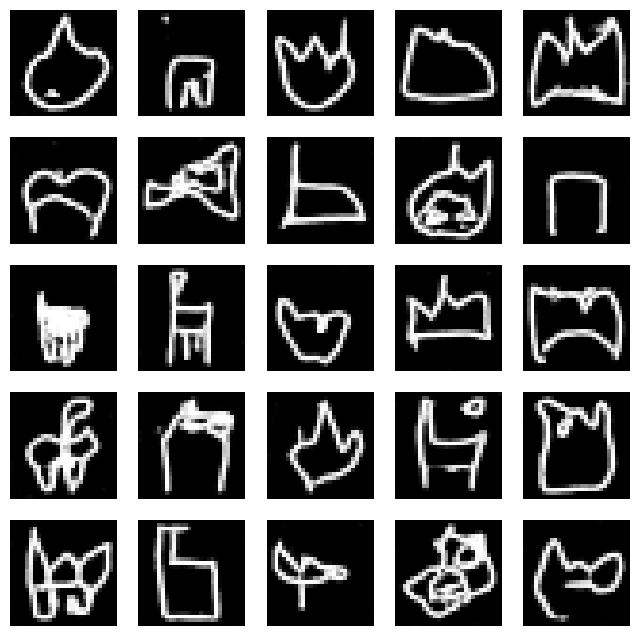

Discriminator output for generated images: 0.0171


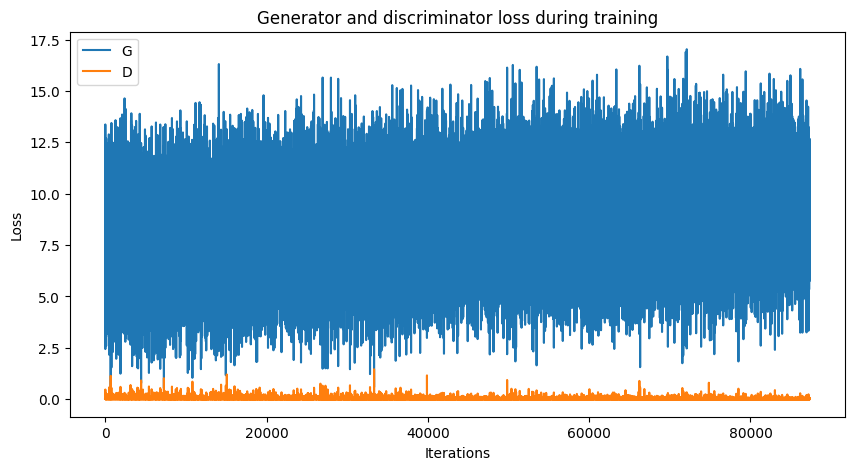

Epoch [16/20] Batch [500/5824] | D loss: 0.0068 G loss: 10.3458
Epoch [16/20] Batch [1000/5824] | D loss: 0.0045 G loss: 7.7960
Epoch [16/20] Batch [1500/5824] | D loss: 0.0016 G loss: 9.5133
Epoch [16/20] Batch [2000/5824] | D loss: 0.0130 G loss: 7.0500
Epoch [16/20] Batch [2500/5824] | D loss: 0.0047 G loss: 7.3376
Epoch [16/20] Batch [3000/5824] | D loss: 0.0065 G loss: 9.5477
Epoch [16/20] Batch [3500/5824] | D loss: 0.0010 G loss: 10.3532
Epoch [16/20] Batch [4000/5824] | D loss: 0.0143 G loss: 8.0112
Epoch [16/20] Batch [4500/5824] | D loss: 0.0060 G loss: 10.1125
Epoch [16/20] Batch [5000/5824] | D loss: 0.0014 G loss: 9.6946
Epoch [16/20] Batch [5500/5824] | D loss: 0.0058 G loss: 8.0581
==> Epoch [16/20] | Avg D loss: 0.0100 Avg G loss: 9.3754
Epoch [17/20] Batch [500/5824] | D loss: 0.0023 G loss: 10.1325
Epoch [17/20] Batch [1000/5824] | D loss: 0.0088 G loss: 8.7552
Epoch [17/20] Batch [1500/5824] | D loss: 0.0035 G loss: 8.9791
Epoch [17/20] Batch [2000/5824] | D loss: 0.

In [ ]:
train_GAN(epochs, dataloader)

In [ ]:
# Save model to .h5 file
def save_model(model, filename):
    torch.save(model.state_dict(), filename)
    print(f"Model saved to {filename}")

In [36]:
save_model(generator, "GAN_generator_model.h5")
save_model(discriminator, "GAN_discriminator_model.h5")

Model saved to GAN_generator_model.h5
Model saved to GAN_discriminator_model.h5


### **VAE**

In [26]:
import math

def train_vae(model, dataloader, epochs, device, learning_rate=1e-3):
    # Adam optimizer for model parameters
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()  # Set model to training mode
    for epoch in range(epochs):
        total_loss = 0
        recon_loss = 0
        kl_loss = 0

        for batch in dataloader:
            batch = batch.to(device)
            optimizer.zero_grad()  # Clear the gradients

            # Forward pass: encode, sample, and decode
            recon_batch, mu, log_var = model(batch)

            # Reconstruction loss: Mean Squared Error
            recon = F.mse_loss(recon_batch, batch, reduction='sum')

            # KL divergence loss: Encourages latent space to match unit Gaussian
            kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

            # Total loss is the sum of reconstruction and KL divergence losses
            loss = recon + kl

            # Backward pass: compute gradients and update weights
            loss.backward()
            optimizer.step()

            # Accumulate losses for reporting
            total_loss += loss.item()
            recon_loss += recon.item()
            kl_loss += kl.item()

        # Compute average losses per sample for the epoch
        avg_loss = total_loss / len(dataloader.dataset)
        avg_recon = recon_loss / len(dataloader.dataset)
        avg_kl = kl_loss / len(dataloader.dataset)

        # Print epoch statistics
        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'Average Loss: {avg_loss:.4f}')
        print(f'Reconstruction Loss: {avg_recon:.4f}')
        print(f'KL Loss: {avg_kl:.4f}\n')

        # Generate and plot samples every 20 epochs
        if (epoch + 1) % 20 == 0:
            model.eval()  # Set model to evaluation mode
            generated = model.generate(25, device)  # Generate 25 images
            # Convert generated tensors to numpy arrays for visualization
            generated = generated.cpu().detach().numpy()

            grid_size = int(math.sqrt(25))  # Assumes 25 images in a square grid

            plt.figure(figsize=(8, 8))
            for i in range(25):
                plt.subplot(grid_size, grid_size, i + 1)
                plt.imshow(generated[i][0], cmap='gray', interpolation='none')
                plt.axis('off')
            plt.suptitle('Generated images')
            plt.show()
            model.train()  # Set model back to training mode

    return model

In [20]:
epochs = 200
learning_rate = 0.0001

Epoch [1/200]
Average Loss: 102.9544
Reconstruction Loss: 60.2969
KL Loss: 42.6575

Epoch [2/200]
Average Loss: 102.8348
Reconstruction Loss: 60.1770
KL Loss: 42.6578

Epoch [3/200]
Average Loss: 102.6983
Reconstruction Loss: 60.0469
KL Loss: 42.6515

Epoch [4/200]
Average Loss: 102.5851
Reconstruction Loss: 59.9471
KL Loss: 42.6380

Epoch [5/200]
Average Loss: 102.4796
Reconstruction Loss: 59.8384
KL Loss: 42.6412

Epoch [6/200]
Average Loss: 102.3382
Reconstruction Loss: 59.7175
KL Loss: 42.6207

Epoch [7/200]
Average Loss: 102.2521
Reconstruction Loss: 59.6288
KL Loss: 42.6233

Epoch [8/200]
Average Loss: 102.1459
Reconstruction Loss: 59.5299
KL Loss: 42.6160

Epoch [9/200]
Average Loss: 102.0532
Reconstruction Loss: 59.4373
KL Loss: 42.6160

Epoch [10/200]
Average Loss: 101.9543
Reconstruction Loss: 59.3447
KL Loss: 42.6096

Epoch [11/200]
Average Loss: 101.8582
Reconstruction Loss: 59.2539
KL Loss: 42.6043

Epoch [12/200]
Average Loss: 101.7748
Reconstruction Loss: 59.1773
KL Loss

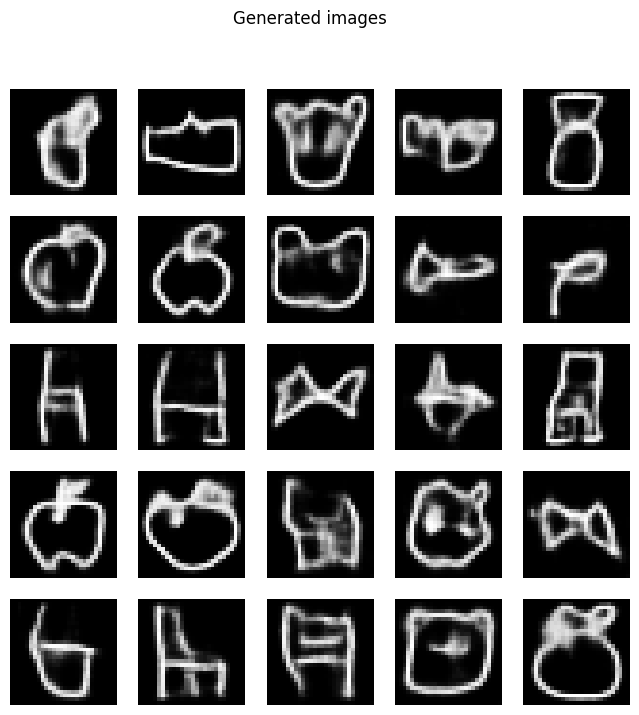

Epoch [21/200]
Average Loss: 101.0905
Reconstruction Loss: 58.5245
KL Loss: 42.5660

Epoch [22/200]
Average Loss: 101.0244
Reconstruction Loss: 58.4712
KL Loss: 42.5532

Epoch [23/200]
Average Loss: 100.9691
Reconstruction Loss: 58.4138
KL Loss: 42.5553

Epoch [24/200]
Average Loss: 100.9063
Reconstruction Loss: 58.3490
KL Loss: 42.5572

Epoch [25/200]
Average Loss: 100.8271
Reconstruction Loss: 58.2902
KL Loss: 42.5369

Epoch [26/200]
Average Loss: 100.7639
Reconstruction Loss: 58.2278
KL Loss: 42.5361

Epoch [27/200]
Average Loss: 100.7130
Reconstruction Loss: 58.1799
KL Loss: 42.5330

Epoch [28/200]
Average Loss: 100.6436
Reconstruction Loss: 58.1245
KL Loss: 42.5191

Epoch [29/200]
Average Loss: 100.5992
Reconstruction Loss: 58.0798
KL Loss: 42.5194

Epoch [30/200]
Average Loss: 100.5246
Reconstruction Loss: 58.0151
KL Loss: 42.5095

Epoch [31/200]
Average Loss: 100.4811
Reconstruction Loss: 57.9718
KL Loss: 42.5093

Epoch [32/200]
Average Loss: 100.4182
Reconstruction Loss: 57.923

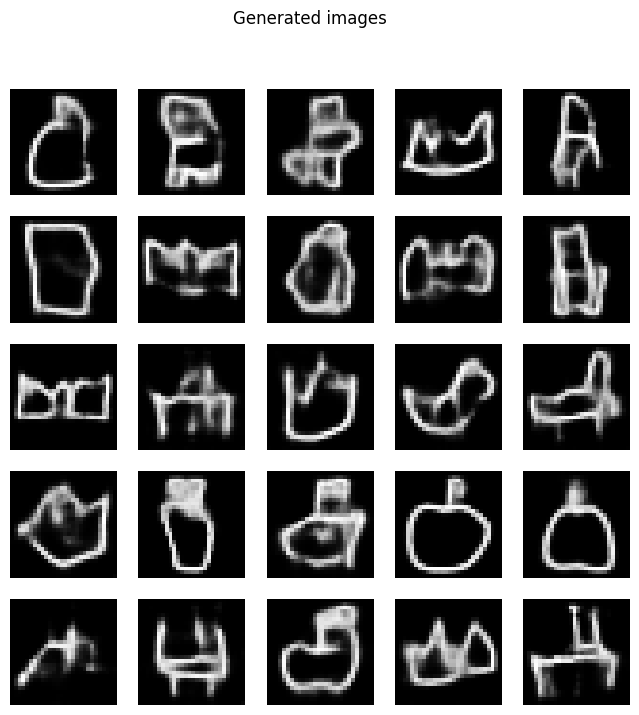

Epoch [41/200]
Average Loss: 99.9828
Reconstruction Loss: 57.5247
KL Loss: 42.4581

Epoch [42/200]
Average Loss: 99.9418
Reconstruction Loss: 57.4905
KL Loss: 42.4513

Epoch [43/200]
Average Loss: 99.9014
Reconstruction Loss: 57.4507
KL Loss: 42.4507

Epoch [44/200]
Average Loss: 99.8431
Reconstruction Loss: 57.4154
KL Loss: 42.4277

Epoch [45/200]
Average Loss: 99.7870
Reconstruction Loss: 57.3594
KL Loss: 42.4276

Epoch [46/200]
Average Loss: 99.7539
Reconstruction Loss: 57.3327
KL Loss: 42.4212

Epoch [47/200]
Average Loss: 99.7101
Reconstruction Loss: 57.2940
KL Loss: 42.4161

Epoch [48/200]
Average Loss: 99.6758
Reconstruction Loss: 57.2592
KL Loss: 42.4166

Epoch [49/200]
Average Loss: 99.6383
Reconstruction Loss: 57.2304
KL Loss: 42.4079

Epoch [50/200]
Average Loss: 99.5922
Reconstruction Loss: 57.1865
KL Loss: 42.4056

Epoch [51/200]
Average Loss: 99.5329
Reconstruction Loss: 57.1391
KL Loss: 42.3938

Epoch [52/200]
Average Loss: 99.4966
Reconstruction Loss: 57.1096
KL Loss: 4

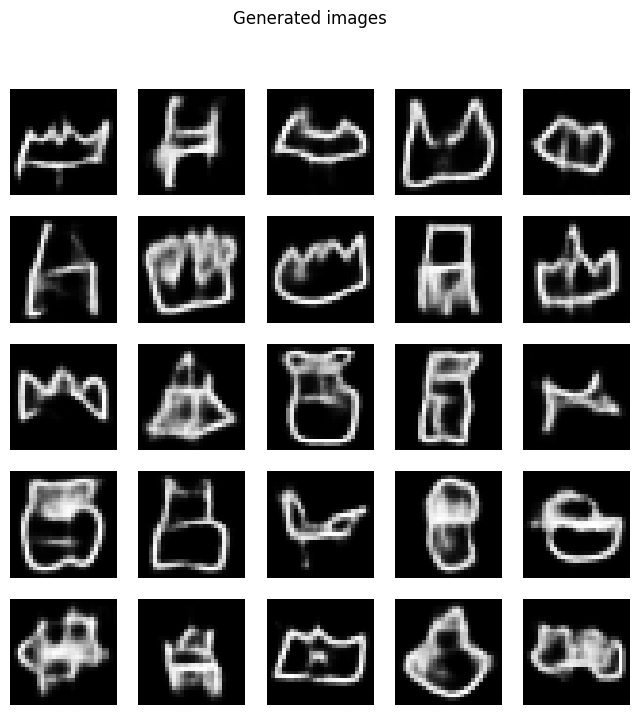

Epoch [61/200]
Average Loss: 99.1583
Reconstruction Loss: 56.7969
KL Loss: 42.3615

Epoch [62/200]
Average Loss: 99.1288
Reconstruction Loss: 56.7754
KL Loss: 42.3533

Epoch [63/200]
Average Loss: 99.0992
Reconstruction Loss: 56.7383
KL Loss: 42.3609

Epoch [64/200]
Average Loss: 99.0533
Reconstruction Loss: 56.7094
KL Loss: 42.3439

Epoch [65/200]
Average Loss: 99.0445
Reconstruction Loss: 56.6874
KL Loss: 42.3571

Epoch [66/200]
Average Loss: 98.9975
Reconstruction Loss: 56.6513
KL Loss: 42.3462

Epoch [67/200]
Average Loss: 98.9653
Reconstruction Loss: 56.6135
KL Loss: 42.3518

Epoch [68/200]
Average Loss: 98.9378
Reconstruction Loss: 56.5910
KL Loss: 42.3468

Epoch [69/200]
Average Loss: 98.9197
Reconstruction Loss: 56.5707
KL Loss: 42.3490

Epoch [70/200]
Average Loss: 98.8839
Reconstruction Loss: 56.5368
KL Loss: 42.3471

Epoch [71/200]
Average Loss: 98.8596
Reconstruction Loss: 56.5236
KL Loss: 42.3360

Epoch [72/200]
Average Loss: 98.8340
Reconstruction Loss: 56.4957
KL Loss: 4

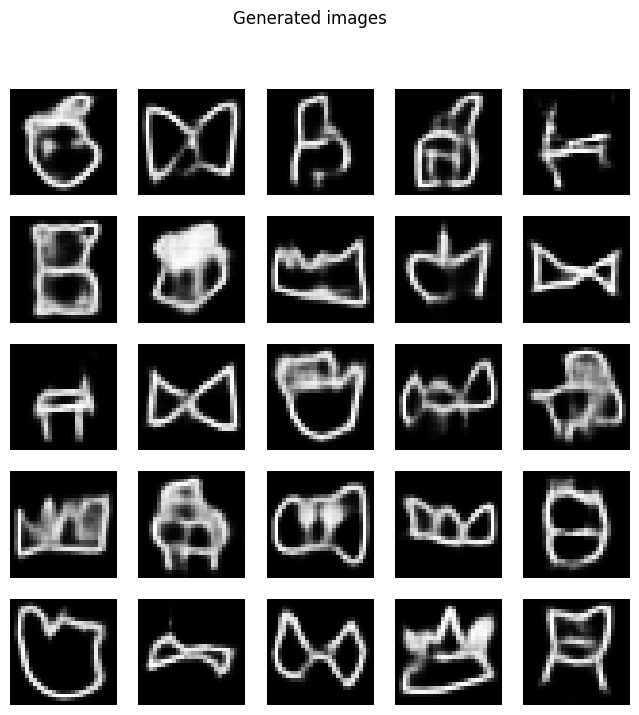

Epoch [81/200]
Average Loss: 98.6280
Reconstruction Loss: 56.2844
KL Loss: 42.3436

Epoch [82/200]
Average Loss: 98.6027
Reconstruction Loss: 56.2673
KL Loss: 42.3354

Epoch [83/200]
Average Loss: 98.5754
Reconstruction Loss: 56.2338
KL Loss: 42.3416

Epoch [84/200]
Average Loss: 98.5694
Reconstruction Loss: 56.2297
KL Loss: 42.3397

Epoch [85/200]
Average Loss: 98.5516
Reconstruction Loss: 56.1967
KL Loss: 42.3548

Epoch [86/200]
Average Loss: 98.5118
Reconstruction Loss: 56.1744
KL Loss: 42.3374

Epoch [87/200]
Average Loss: 98.5039
Reconstruction Loss: 56.1546
KL Loss: 42.3493

Epoch [88/200]
Average Loss: 98.4738
Reconstruction Loss: 56.1251
KL Loss: 42.3487

Epoch [89/200]
Average Loss: 98.4708
Reconstruction Loss: 56.1223
KL Loss: 42.3484

Epoch [90/200]
Average Loss: 98.4532
Reconstruction Loss: 56.1086
KL Loss: 42.3445

Epoch [91/200]
Average Loss: 98.4182
Reconstruction Loss: 56.0834
KL Loss: 42.3348

Epoch [92/200]
Average Loss: 98.4081
Reconstruction Loss: 56.0566
KL Loss: 4

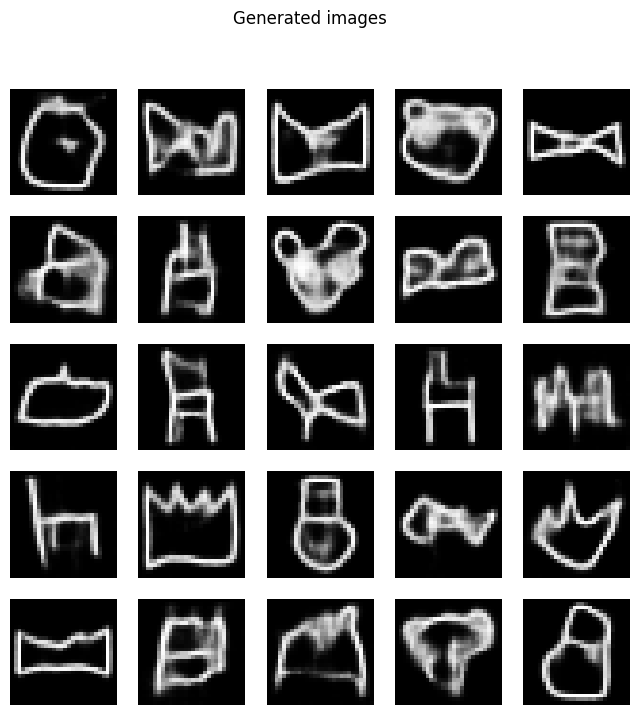

Epoch [101/200]
Average Loss: 98.2477
Reconstruction Loss: 55.9056
KL Loss: 42.3420

Epoch [102/200]
Average Loss: 98.2329
Reconstruction Loss: 55.8912
KL Loss: 42.3417

Epoch [103/200]
Average Loss: 98.2136
Reconstruction Loss: 55.8765
KL Loss: 42.3371

Epoch [104/200]
Average Loss: 98.1890
Reconstruction Loss: 55.8582
KL Loss: 42.3308

Epoch [105/200]
Average Loss: 98.1794
Reconstruction Loss: 55.8325
KL Loss: 42.3469

Epoch [106/200]
Average Loss: 98.1609
Reconstruction Loss: 55.8216
KL Loss: 42.3393

Epoch [107/200]
Average Loss: 98.1533
Reconstruction Loss: 55.8028
KL Loss: 42.3505

Epoch [108/200]
Average Loss: 98.1361
Reconstruction Loss: 55.7889
KL Loss: 42.3472

Epoch [109/200]
Average Loss: 98.1254
Reconstruction Loss: 55.7713
KL Loss: 42.3541

Epoch [110/200]
Average Loss: 98.0884
Reconstruction Loss: 55.7518
KL Loss: 42.3365

Epoch [111/200]
Average Loss: 98.0932
Reconstruction Loss: 55.7470
KL Loss: 42.3462

Epoch [112/200]
Average Loss: 98.0753
Reconstruction Loss: 55.728

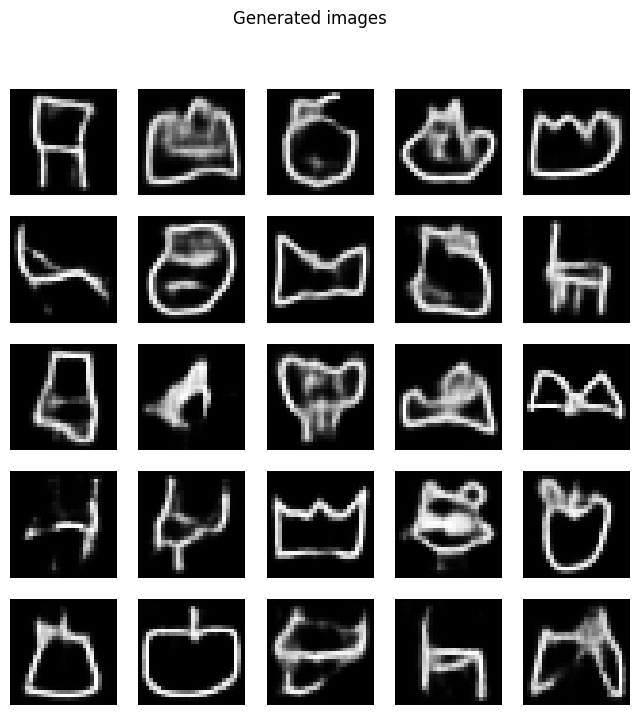

Epoch [121/200]
Average Loss: 97.9461
Reconstruction Loss: 55.5916
KL Loss: 42.3545

Epoch [122/200]
Average Loss: 97.9387
Reconstruction Loss: 55.5751
KL Loss: 42.3636

Epoch [123/200]
Average Loss: 97.9243
Reconstruction Loss: 55.5659
KL Loss: 42.3584

Epoch [124/200]
Average Loss: 97.9071
Reconstruction Loss: 55.5644
KL Loss: 42.3426

Epoch [125/200]
Average Loss: 97.8930
Reconstruction Loss: 55.5492
KL Loss: 42.3438

Epoch [126/200]
Average Loss: 97.8787
Reconstruction Loss: 55.5346
KL Loss: 42.3441

Epoch [127/200]
Average Loss: 97.8720
Reconstruction Loss: 55.5131
KL Loss: 42.3589

Epoch [128/200]
Average Loss: 97.8518
Reconstruction Loss: 55.5092
KL Loss: 42.3427

Epoch [129/200]
Average Loss: 97.8460
Reconstruction Loss: 55.4925
KL Loss: 42.3535

Epoch [130/200]
Average Loss: 97.8190
Reconstruction Loss: 55.4789
KL Loss: 42.3401

Epoch [131/200]
Average Loss: 97.8087
Reconstruction Loss: 55.4587
KL Loss: 42.3500

Epoch [132/200]
Average Loss: 97.8096
Reconstruction Loss: 55.456

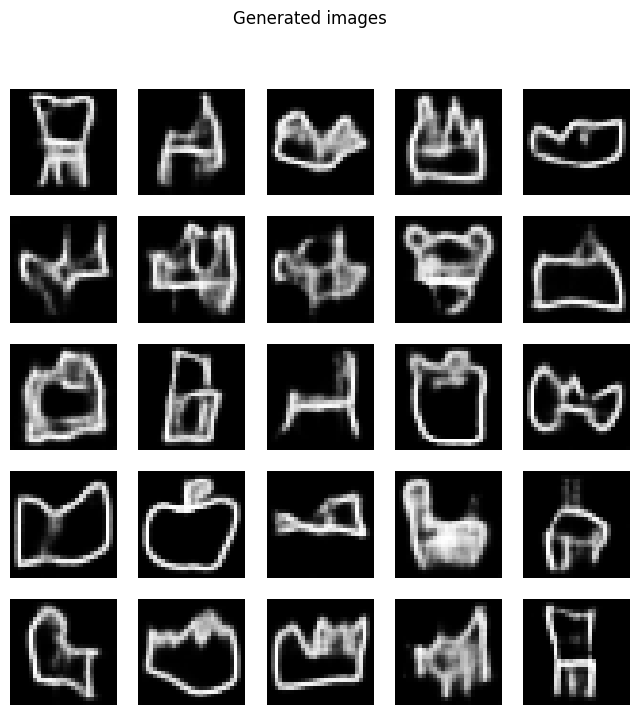

Epoch [141/200]
Average Loss: 97.7074
Reconstruction Loss: 55.3491
KL Loss: 42.3583

Epoch [142/200]
Average Loss: 97.6822
Reconstruction Loss: 55.3368
KL Loss: 42.3454

Epoch [143/200]
Average Loss: 97.6785
Reconstruction Loss: 55.3258
KL Loss: 42.3527

Epoch [144/200]
Average Loss: 97.6658
Reconstruction Loss: 55.3108
KL Loss: 42.3550

Epoch [145/200]
Average Loss: 97.6520
Reconstruction Loss: 55.3000
KL Loss: 42.3519

Epoch [146/200]
Average Loss: 97.6457
Reconstruction Loss: 55.2860
KL Loss: 42.3598

Epoch [147/200]
Average Loss: 97.6208
Reconstruction Loss: 55.2792
KL Loss: 42.3416

Epoch [148/200]
Average Loss: 97.6025
Reconstruction Loss: 55.2558
KL Loss: 42.3467

Epoch [149/200]
Average Loss: 97.6141
Reconstruction Loss: 55.2549
KL Loss: 42.3592

Epoch [150/200]
Average Loss: 97.5956
Reconstruction Loss: 55.2414
KL Loss: 42.3542

Epoch [151/200]
Average Loss: 97.5837
Reconstruction Loss: 55.2296
KL Loss: 42.3540

Epoch [152/200]
Average Loss: 97.5808
Reconstruction Loss: 55.226

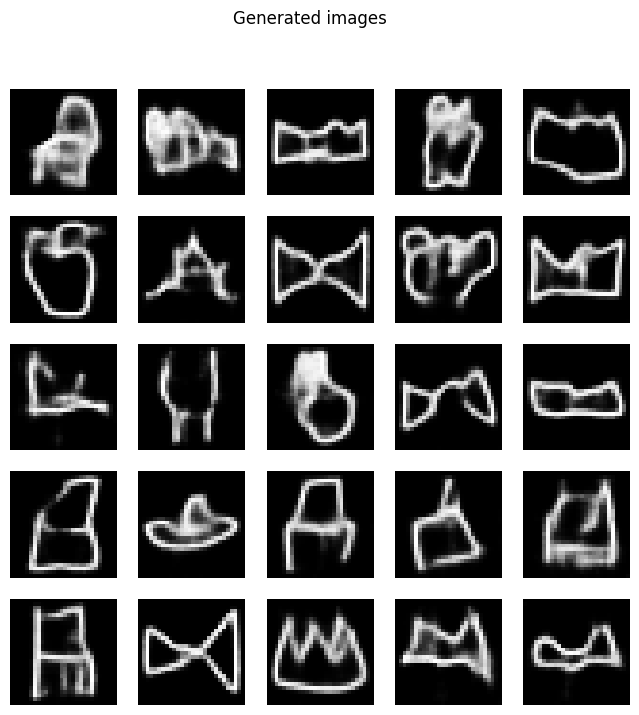

Epoch [161/200]
Average Loss: 97.4763
Reconstruction Loss: 55.1264
KL Loss: 42.3499

Epoch [162/200]
Average Loss: 97.4430
Reconstruction Loss: 55.1105
KL Loss: 42.3325

Epoch [163/200]
Average Loss: 97.4458
Reconstruction Loss: 55.0978
KL Loss: 42.3480

Epoch [164/200]
Average Loss: 97.4294
Reconstruction Loss: 55.0925
KL Loss: 42.3369

Epoch [165/200]
Average Loss: 97.4182
Reconstruction Loss: 55.0837
KL Loss: 42.3345

Epoch [166/200]
Average Loss: 97.4071
Reconstruction Loss: 55.0760
KL Loss: 42.3312

Epoch [167/200]
Average Loss: 97.3897
Reconstruction Loss: 55.0487
KL Loss: 42.3410

Epoch [168/200]
Average Loss: 97.3821
Reconstruction Loss: 55.0384
KL Loss: 42.3437

Epoch [169/200]
Average Loss: 97.3551
Reconstruction Loss: 55.0295
KL Loss: 42.3256

Epoch [170/200]
Average Loss: 97.3391
Reconstruction Loss: 55.0121
KL Loss: 42.3270

Epoch [171/200]
Average Loss: 97.3611
Reconstruction Loss: 55.0224
KL Loss: 42.3387

Epoch [172/200]
Average Loss: 97.3251
Reconstruction Loss: 55.000

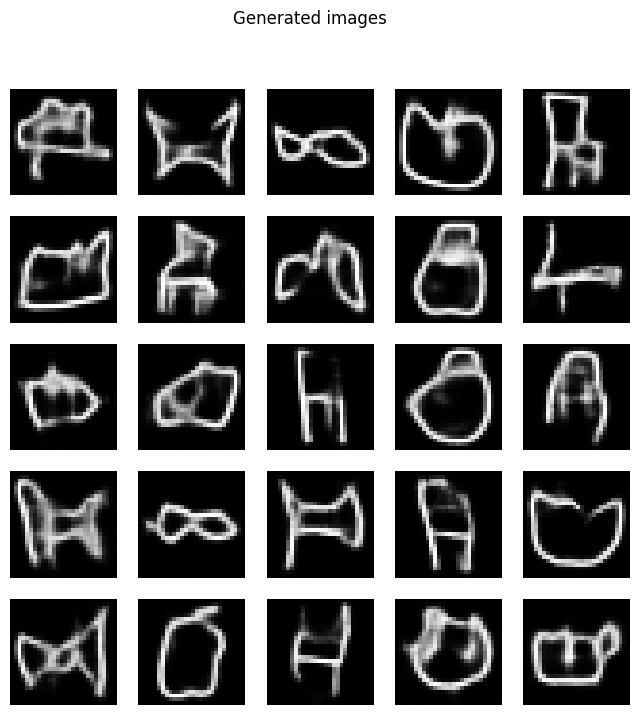

Epoch [181/200]
Average Loss: 97.2459
Reconstruction Loss: 54.9191
KL Loss: 42.3268

Epoch [182/200]
Average Loss: 97.2345
Reconstruction Loss: 54.9078
KL Loss: 42.3267

Epoch [183/200]
Average Loss: 97.2376
Reconstruction Loss: 54.8991
KL Loss: 42.3385

Epoch [184/200]
Average Loss: 97.2079
Reconstruction Loss: 54.8929
KL Loss: 42.3150

Epoch [185/200]
Average Loss: 97.2036
Reconstruction Loss: 54.8844
KL Loss: 42.3191

Epoch [186/200]
Average Loss: 97.2027
Reconstruction Loss: 54.8751
KL Loss: 42.3276

Epoch [187/200]
Average Loss: 97.1769
Reconstruction Loss: 54.8613
KL Loss: 42.3156

Epoch [188/200]
Average Loss: 97.1797
Reconstruction Loss: 54.8584
KL Loss: 42.3213

Epoch [189/200]
Average Loss: 97.1522
Reconstruction Loss: 54.8430
KL Loss: 42.3092

Epoch [190/200]
Average Loss: 97.1607
Reconstruction Loss: 54.8387
KL Loss: 42.3220

Epoch [191/200]
Average Loss: 97.1602
Reconstruction Loss: 54.8364
KL Loss: 42.3238

Epoch [192/200]
Average Loss: 97.1401
Reconstruction Loss: 54.826

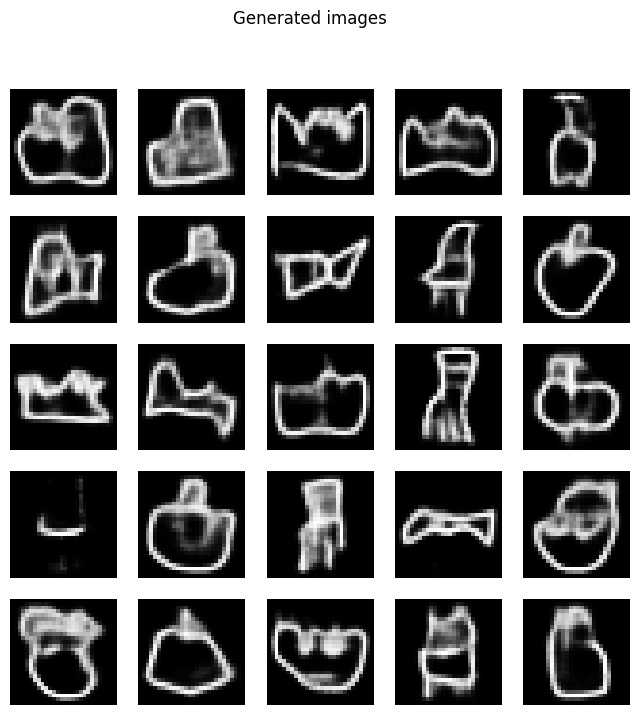

In [27]:
model = train_vae(
    model=vae_model,
    dataloader=dataloader,
    epochs=epochs,
    device=device,
    learning_rate=learning_rate
)

In [28]:
file_name = "VAE_model.h5"
torch.save(vae_model.state_dict(), file_name)
print(f"Model saved to {file_name}")

Model saved to VAE_model.h5


### **Results analysis**

**GAN Performance Analysis:**
1. Training Configuration and Loss Dynamics:
- Architecture uses Binary Cross-Entropy (BCELoss) for adversarial training
- Adam optimizer with lr=0.00015 and betas=(0.5, 0.9) for both networks
- Generator Loss exhibits high volatility (ranging ~2.5-15)
- Discriminator Loss remains stable and low (~0.2-0.5)


2. Parameter Impact on Training:
- The relatively low learning rate (0.00015) aimed for stability but may need further tuning
- Equal learning rates for G and D might contribute to the observed generator instability
- Modified Adam betas (0.5, 0.9) help with training stability but haven't fully prevented oscillations 20 epochs might be insufficient for full convergence given the learning rate


3. Visual Output Analysis (Quick Draw Dataset):
- Class-Specific Performance:
-- Chairs: Good structural consistency but some perspective issues
-- Crowns: Recognizable points but varying symmetry
-- Apples: Simple shape well-captured
-- Pandas: Basic features present but anatomical inconsistencies
-- Bowties: Maintains symmetry but limited style variation

- Strengths:
-- Generated images maintain recognizable class features
-- Basic structural elements preserved (chair legs, crown points, etc.)
-- Line quality matches Quick Draw's sketch-like nature
-- Clear class differentiation between objects

- Weaknesses:
-- Inconsistent line connectivity
-- Some structural distortions
-- Limited variation within classes
-- Occasional artifacts

**VAE performance analysis**

1. Loss Components Analysis:
- Final metrics at epoch 200:
- Total Average Loss: ~97.08
- Reconstruction Loss: ~54.77 (56.4% of total loss)
- KL Loss: ~42.32 (43.6% of total loss)

Loss Evolution:
- Relatively stable through epochs
- Small improvements (~0.02 decrease in average loss)
- Balance between reconstruction and KL loss maintained

2. Training Parameters:
- Epochs: 200 (significantly longer than GAN's 20 epochs)
- Learning rate: 0.0001 (slightly lower than GAN's 0.00015)
- The longer training time and lower learning rate contribute to stability


3. Generated Images Quality:
- Class-Specific Analysis:
-- Chairs: Basic structure maintained but some perspective inconsistencies
-- Bowties: Symmetrical features preserved but softer edges
-- Apples: Round shapes captured well but less distinct stems
-- Crown: Points and basic shape visible but less defined
-- Panda: Basic face structure present but details are more blurred
- Strengths:
-- Consistent line thickness across samples
-- Good basic shape preservation
-- Smooth, continuous lines
-- Clear class distinctions

- Weaknesses:
-- Slight blurriness compared to GAN outputs
-- Less sharp details
-- Some shape distortions
-- Reduced contrast compared to original sketches